In [1]:
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten, LSTM, BatchNormalization
from keras.utils import np_utils
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
import os
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
import cv2
from urllib.parse import urlparse
from skimage.io import imread
from PIL import Image
from skimage.transform import resize
from keras import Input, Model
import random


In [2]:
face_scrub_actors_data = os.path.join('data/faceScrub', 'facescrub_actors.txt')
face_scrub_actress_data = os.path.join('data/faceScrub', 'facescrub_actresses.txt')
actors_dir = os.path.join('data', 'actors')
actress_dir = os.path.join('data', 'actress')


In [3]:
class Rectangle:
    def __init__(self, x, y, width, height):
        self.x = x
        self.y = y
        self.width = width
        self.height = height


In [4]:
class FaceData:
    image = None
    def __init__(self, url, path, rect, sha256hash):
        self.url = url
        self.path = path
        self.rect = rect
        self.sha256hash = sha256hash


In [5]:
def read_txt_file(path):
    with open(path) as f:
     lines = f.readlines()
     return lines


In [6]:
actors_lines = read_txt_file(face_scrub_actors_data)
actress_lines = read_txt_file(face_scrub_actress_data)


In [7]:
def create_actor_object(image_path ,actor):
    data = actor.split()
    data_len = len(data)
    url = data[data_len - 3]
    rect_data = data[data_len - 2].split(',')
    rect = Rectangle(int(rect_data[0]), int(rect_data[1]), int(rect_data[2]), int(rect_data[3]))
    a = urlparse(url)
    path = os.path.join(image_path, os.path.basename(a.path))
    face = FaceData(url, path, rect, data[data_len - 1])
    return face


In [28]:
len(actors_lines)


55307

In [8]:
def contains_record(path, faces):
    for face in faces:
        if face.path == path:
            return True
    return False


In [9]:
faces = list()
for x in range(1, len(actors_lines)):
    actor = actors_lines[x]
    face = create_actor_object(actors_dir, actor)
    if os.path.exists(face.path):
       if contains_record(face.path, faces) == False:
           faces.append(face)
# for actor in actors_lines:
#     face = create_actor_object(actor)
#     a = urlparse(face.url)
#     path = os.path.join(actors_dir, os.path.basename(a.path))
#     if os.path.exists(path):
#         faces.append(face)


In [10]:

len(faces)

1317

In [11]:
for x in range(1, len(actress_lines)):
    actor = actress_lines[x]
    face = create_actor_object(actress_dir,actor)
    if os.path.exists(face.path):
        if contains_record(face.path, faces) == False:
           faces.append(face)


In [23]:
faces[0].path

'data/actors/original.jpg'

In [12]:
def load_image(path):
    return imread(path)


In [13]:
def read_image(path):
    img = Image.open(path).convert('RGB')
    return np.asarray(img)


In [14]:
imgc = read_image('data/actors/0_61_benicio_del_toro.jpg')
imgc

array([[[69, 51, 37],
        [69, 51, 37],
        [69, 51, 37],
        ...,
        [39, 30, 21],
        [39, 30, 21],
        [39, 30, 21]],

       [[69, 51, 37],
        [69, 51, 37],
        [69, 51, 37],
        ...,
        [39, 30, 21],
        [39, 30, 21],
        [39, 30, 21]],

       [[69, 51, 37],
        [69, 51, 37],
        [69, 51, 37],
        ...,
        [39, 30, 21],
        [39, 30, 21],
        [39, 30, 21]],

       ...,

       [[61, 56, 62],
        [43, 38, 44],
        [36, 31, 37],
        ...,
        [25, 20, 17],
        [24, 19, 16],
        [22, 17, 14]],

       [[60, 55, 61],
        [46, 41, 47],
        [37, 32, 38],
        ...,
        [25, 20, 17],
        [23, 18, 15],
        [22, 17, 14]],

       [[57, 52, 58],
        [49, 44, 50],
        [41, 36, 42],
        ...,
        [26, 21, 18],
        [23, 18, 15],
        [21, 16, 13]]], dtype=uint8)

In [15]:
valid_faces = list()
for face in faces:
    try:
        face.image = read_image(face.path)
        valid_faces.append(face)
    except:
        pass


/Users/ernestopoku-kwarteng/Documents/Pycharm Projects/Anaconda/Machine-Learning/ml-env/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:822: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


In [16]:
len(valid_faces)

2897

In [17]:
def display_image(image):
    fig = plt.figure
    plt.imshow(image, cmap='gray')


In [18]:
random.shuffle(valid_faces)

In [19]:
def get_new_image_dimen(image, rect, dimen):
    width = image.shape[1]
    height = image.shape[0]
    new_width = 0
    new_height = 0
    aspect_ratio = width / height
    if width > height:
        new_width = dimen
        new_height = dimen / aspect_ratio
    else:
        new_height = dimen
        new_width = dimen * aspect_ratio
    new_x = rect.x /(width / new_width)
    new_y = rect.y / (height / new_height)
    new_rect_width = rect.width / (width / new_width)
    new_rect_height = rect.height / (height / new_height)
    new_rect = Rectangle(new_x, new_y, new_rect_width, new_rect_height)
    return (new_width, new_height), (new_rect)
    


(240, 320, 3)
(180, 240, 3)


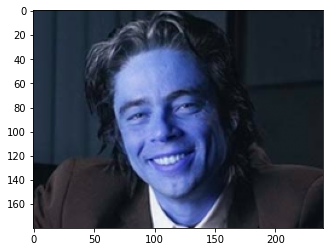

In [104]:
import cv2
x = 77
y = 55
h = 191
w = 213
image = cv2.imread('data/actors/0_61_benicio_del_toro.jpg')
image = np.array(image, np.uint8)
print(image.shape)
display_image(image)
(new_width, new_height), (new_rect) = resize_image(image, Rectangle(x, y, w, h))
im = resize(image, (new_height, new_width))
display_image(im)
print(im.shape)


In [20]:
def show_rect(image, x, y, width, height, timeout = 30000):
    cv2.rectangle(image, (int(x), int(y)), (int(
        width), int(height)), (0, 0, 255), 2)
    # show thresh and result
    cv2.imshow("bounding_box", image)
    cv2.waitKey(timeout)
    cv2.destroyAllWindows()


In [21]:
def pad_image(image, max_size):
    old_image_height, old_image_width, channels = image.shape
    # create new image of desired size and color (blue) for padding
    new_image_width = max_size
    new_image_height = max_size
    color = (0, 0, 0)
    result = np.full((new_image_height, new_image_width,
                  channels), color, dtype=np.uint8)
    # compute center offset
    x_center = (new_image_width - old_image_width) // 2
    y_center = (new_image_height - old_image_height) // 2
    # print(image)
    # copy img image into center of result image
    # result[y_center:y_center+old_image_height,x_center:x_center+old_image_width] = image
    result[0:old_image_height,0:old_image_width] = image
    return result


In [22]:
#Convert all images to gray-scale
def convert_to_gray_scale(image):
    image = np.array(image, np.uint8)
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

In [23]:
len(valid_faces)

2897

In [24]:
#remove records or images with invalid bounding boxes
temp_valid_faces = list()
for face in valid_faces:
    image = face.image
    img_width = image.shape[1]
    img_height = image.shape[0]
    if (face.rect.x + face.rect.width) <= img_width and (face.rect.y + face.rect.height) <= img_height:
        temp_valid_faces.append(face)
len(temp_valid_faces)

1339

In [25]:
valid_faces = temp_valid_faces
temp_valid_faces = None

In [26]:
len(valid_faces)

1339

In [27]:
image_dimen = 600
final_images = [None]*len(valid_faces)
final_rect = [None]*len(valid_faces)
for x in range(len(valid_faces)):
    face = valid_faces[x]
    (new_width, new_height), (new_rect) = get_new_image_dimen(
        face.image, face.rect, image_dimen)
    im = resize(face.image, (new_height, new_width),
            preserve_range=True, mode='edge', order=0)
    im = pad_image(im, image_dimen)
    final_images[x] = im
    final_rect[x] = [new_rect.x, new_rect.y, new_rect.width, new_rect.height]


In [28]:
valid_faces = None
len(final_images)

1339

In [29]:
c = 0
for x in range(len(final_rect)):
    for d in final_rect[x]:
        if d > image_dimen:
            c += 1
            # print(x)
c


0

In [30]:
def train_test_split(train_percentage, images, landmarks):
    data_len = images.shape[0]
    train_val = int(data_len * (train_percentage / 100))
    train_images = [0]*train_val
    train_landmarks = [0]*train_val
    test_images = [0] * (data_len - train_val)
    test_landmarks = [0] * (data_len - train_val)
    i = 0
    for x in range(data_len):
        if x < train_val:
            train_images[x] = images[x]
            train_landmarks[x] = landmarks[x]
        else:
            test_images[i] = images[x]
            test_landmarks[i] = landmarks[x]
            i += 1
    return (train_images, train_landmarks), (test_images, test_landmarks)


In [31]:
#convert all images to grayscale
for x in range(0, len(final_images)):
    final_images[x] = convert_to_gray_scale(final_images[x])

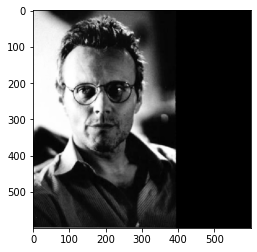

In [32]:
display_image(final_images[0])

In [33]:
(train_images, train_rects), (test_images, test_rects) = train_test_split(90, np.array(final_images), final_rect)


In [34]:
final_images = None
final_rect = None

In [35]:
# print(len(train_images))
#normalize data
x_train = np.array(train_images) / 255
y_train = np.array(train_rects) / image_dimen
x_test = np.array(test_images) / 255
y_test = np.array(test_rects) / image_dimen


In [36]:
x_train.shape

(1205, 600, 600)

In [315]:
## Loading VGG16 model
base_model = VGG16(weights="imagenet", include_top=False,
                   input_shape=(image_dimen, image_dimen, 1))
base_model.trainable = False  # Not trainable weights
base_model.summary()


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 240, 240, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 240, 240, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 120, 120, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 120, 120, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 120, 120, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 60, 60, 128)       0     

In [316]:
conv_1 = Conv2D(256, kernel_size=(1, 1), strides=2, activation='relu')
batch_1 = BatchNormalization()
# convolutional layer
conv_2 = Conv2D(128, kernel_size=(3, 3), strides=1, activation='relu')
conv_3 = Conv2D(128, kernel_size=(3, 3), strides=1, activation='relu')
flatten_layer = Flatten()
dense_layer_1 = Dense(120, activation='relu')
dense_layer_2 = Dense(60, activation='relu')
prediction_layer = Dense(4, activation='sigmoid')
# model = Sequential([base_model,custom_model])
model = Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])
# compiling the sequential model
model.compile(loss='mse', metrics=['accuracy'],
              optimizer='adam')
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dense_6 (Dense)             (None, 120)               3010680   
                                                                 
 dense_7 (Dense)             (None, 60)                7260      
                                                                 
 dense_8 (Dense)             (None, 4)                 244       
                                                                 
Total params: 17,732,872
Trainable params: 3,018,184
Non-trainable params: 14,714,688
_________________________________________________________________


In [91]:
# load the VGG16 network, ensuring the head FC layers are left off
vgg = VGG16(weights="imagenet", include_top=False,
            input_tensor=Input(shape=(image_dimen, image_dimen, 1))
# freeze all VGG layers so they will *not* be updated during the
# training process
vgg.trainable = False
# flatten the max-pooling output of VGG
flatten = vgg.output
flatten = Flatten()(flatten)
# construct a fully-connected layer header to output the predicted
# bounding box coordinates
bboxHead = Dense(128, activation="relu")(flatten)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="sigmoid")(bboxHead)
# construct the model we will fine-tune for bounding box regression
model = Model(inputs=vgg.input, outputs=bboxHead)
# compiling the sequential model
model.compile(loss='mse', metrics=['accuracy'],
              optimizer='adam')
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 300, 300, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 300, 300, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 150, 150, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 150, 150, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 150, 150, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 75, 75, 128)       0     

In [37]:
def EncoderMiniBlock(inputs, n_filters=32, dropout_prob=0.3, max_pooling=True):
    """
    This block uses multiple convolution layers, max pool, relu activation to create an architecture for learning. 
    Dropout can be added for regularization to prevent overfitting. 
    The block returns the activation values for next layer along with a skip connection which will be used in the decoder
    """
    # Add 2 Conv Layers with relu activation and HeNormal initialization using TensorFlow
    # Proper initialization prevents from the problem of exploding and vanishing gradients
    # 'Same' padding will pad the input to conv layer such that the output has the same height and width (hence, is not reduced in size)
    conv = Conv2D(n_filters,
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(inputs)
    conv = Conv2D(n_filters,
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(conv)

    # Batch Normalization will normalize the output of the last layer based on the batch's mean and standard deviation
    conv = BatchNormalization()(conv, training=False)

    # In case of overfitting, dropout will regularize the loss and gradient computation to shrink the influence of weights on output
    if dropout_prob > 0:
        conv = tf.keras.layers.Dropout(dropout_prob)(conv)

    # Pooling reduces the size of the image while keeping the number of channels same
    # Pooling has been kept as optional as the last encoder layer does not use pooling (hence, makes the encoder block flexible to use)
    # Below, Max pooling considers the maximum of the input slice for output computation and uses stride of 2 to traverse across input image
    if max_pooling:
        next_layer = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv)
    else:
        next_layer = conv

    # skip connection (without max pooling) will be input to the decoder layer to prevent information loss during transpose convolutions
    skip_connection = conv

    return next_layer, skip_connection


def DecoderMiniBlock(prev_layer_input, skip_layer_input, n_filters=32):
    """
    Decoder Block first uses transpose convolution to upscale the image to a bigger size and then,
    merges the result with skip layer results from encoder block
    Adding 2 convolutions with 'same' padding helps further increase the depth of the network for better predictions
    The function returns the decoded layer output
    """
    # Start with a transpose convolution layer to first increase the size of the image
    up = Conv2DTranspose(
        n_filters,
        (3, 3),    # Kernel size
        strides=(2, 2),
        padding='same')(prev_layer_input)

    # Merge the skip connection from previous block to prevent information loss
    merge = concatenate([up, skip_layer_input], axis=3)

    # Add 2 Conv Layers with relu activation and HeNormal initialization for further processing
    # The parameters for the function are similar to encoder
    conv = Conv2D(n_filters,
                  3,     # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(merge)
    conv = Conv2D(n_filters,
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(conv)
    return conv


In [ ]:
new_dimen = image_dimen = 600
input_size = (new_dimen, new_dimen, 1)
n_filters = 32
n_classes = 4

# Input size represent the size of 1 image (the size used for pre-processing)
inputs = Input(input_size)

# Encoder includes multiple convolutional mini blocks with different maxpooling, dropout and filter parameters
# Observe that the filters are increasing as we go deeper into the network which will increasse the # channels of the image
cblock1 = EncoderMiniBlock(inputs, n_filters, dropout_prob=0, max_pooling=True)
cblock2 = EncoderMiniBlock(
    cblock1[0], n_filters*2, dropout_prob=0, max_pooling=True)
cblock3 = EncoderMiniBlock(
    cblock2[0], n_filters*4, dropout_prob=0, max_pooling=True)
cblock4 = EncoderMiniBlock(
    cblock3[0], n_filters*8, dropout_prob=0.3, max_pooling=True)
cblock5 = EncoderMiniBlock(
    cblock4[0], n_filters*16, dropout_prob=0.3, max_pooling=False)

# Decoder includes multiple mini blocks with decreasing number of filters
# Observe the skip connections from the encoder are given as input to the decoder
# Recall the 2nd output of encoder block was skip connection, hence cblockn[1] is used
ublock6 = DecoderMiniBlock(cblock5[0], cblock4[1],  n_filters * 8)
ublock7 = DecoderMiniBlock(ublock6, cblock3[1],  n_filters * 4)
ublock8 = DecoderMiniBlock(ublock7, cblock2[1],  n_filters * 2)
ublock9 = DecoderMiniBlock(ublock8, cblock1[1],  n_filters)

# Complete the model with 1 3x3 convolution layer (Same as the prev Conv Layers)
# Followed by a 1x1 Conv layer to get the image to the desired size.
# Observe the number of channels will be equal to number of output classes
conv9 = Conv2D(n_filters,
               3,
               activation='relu',
               padding='same',
               kernel_initializer='he_normal')(ublock9)


conv10 = Conv2D(n_classes, 1, padding='same')(conv9)

# Define the model
model = tf.keras.Model(inputs=inputs, outputs=conv10)
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model.summary()


In [116]:
model.fit(x_train, y_train, epochs=25, batch_size=30,validation_data=(x_test, y_test))


Epoch 1/25
41/41 [==============================] - 1156s 28s/step - loss: 0.0587 - accuracy: 0.4490 - val_loss: 0.1012 - val_accuracy: 0.6866
Epoch 2/25
41/41 [==============================] - 1182s 29s/step - loss: 0.0111 - accuracy: 0.6315 - val_loss: 0.0388 - val_accuracy: 0.6866
Epoch 3/25
41/41 [==============================] - 1169s 28s/step - loss: 0.0093 - accuracy: 0.6822 - val_loss: 0.0372 - val_accuracy: 0.6866
Epoch 4/25
41/41 [==============================] - 1217s 30s/step - loss: 0.0079 - accuracy: 0.7602 - val_loss: 0.0304 - val_accuracy: 0.6866
Epoch 5/25
 8/41 [====>.........................] - ETA: 15:47 - loss: 0.0074 - accuracy: 0.8125

KeyboardInterrupt: 

In [93]:
sample = 1
test_image = x_train[sample].copy()  # x_test[100].copy()
# rgb_test_img = convert_to_rgb(test_image) # x_test[]
test_output = model.predict(np.array([test_image]), verbose=0)
print(test_output)


[[1.1825261e-21 2.7548328e-12 3.9392788e-07 7.3747581e-01]]


In [78]:
y_test[sample]

array([0.15625   , 0.25911458, 0.50260417, 0.60546875])

In [94]:
# test_image = test_image * 255
test_output = test_output * 300
test_output


array([[3.5475783e-19, 8.2644985e-10, 1.1817837e-04, 2.2124274e+02]],
      dtype=float32)

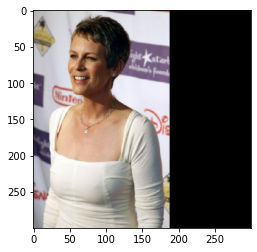

In [80]:
display_image(test_image)

In [81]:
rect_arr = test_output[0]


In [82]:
show_rect(test_image, rect_arr[0], rect_arr[1], rect_arr[2], rect_arr[3], 10000)


TypeError: only size-1 arrays can be converted to Python scalars